# CIFAR10 - DenseNet

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [ ]:
#Creating the training and testing sets 
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

#Creating the Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1, shuffle = True)

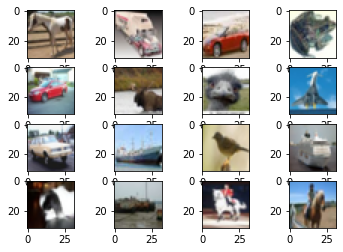

In [ ]:
import matplotlib.pyplot as plt
for i in range(16):
    # define subplot
    plt.subplot(4, 4, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i])
# show the figure
plt.show()

In [ ]:
#One Hot Encoding the Labels
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

In [ ]:
def bn_relu_convolution(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    
    #Creates a convolution layers consisting of BN-ReLU-Conv.
    #Optional: bottleneck, dropout
    
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

    # BN-ReLU-Conv
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

    # Dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

In [ ]:
def bn_relu_transition(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu',)(x)
    x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    # Adding dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

In [ ]:
def dense_block(x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                    weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """

    for i in range(num_layers):
        cb = bn_relu_convolution(x, growth_rate, dropout_rate, 
                                 bottleneck) # 1 conv if bottleneck = 0 else 2 conv if bottleneck = 1
        nb_channels += growth_rate
        x = layers.concatenate([cb, x])
    return x, nb_channels

In [ ]:
def DenseNet(input_shape, dense_blocks, dense_layers, growth_rate, compression, bottleneck, 
                     weight_decay, dropout_rate, num_classes, ):
        """
        Build the model
        Returns: tf Keras Model instance
        """

        print('Creating DenseNet with Bottleneck = {}'.format(bottleneck))
        print('---------------------------------------')
        print('No.of. dense blocks: %s' % dense_blocks)
        print('Layers per dense block: %s' % dense_layers)
        print('---------------------------------------')

        # Input Layer
        img_input = layers.Input(shape=input_shape, name = 'img_input')
        nb_channels = growth_rate

        # Input-convolution layer
        x = layers.Conv2D(2 * growth_rate, (3, 3), padding='same', strides=(1, 1),name='input_conv', 
                          kernel_regularizer= tf.keras.regularizers.l2(weight_decay))(img_input)

        # Building dense blocks
        for block in range(dense_blocks - 1):
            # Add dense_block
            x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate,
                                     dropout_rate, bottleneck, weight_decay) 

            # Add transition
            x = bn_relu_transition(x, nb_channels, dropout_rate, compression, weight_decay) # 1 conv layer
            nb_channels = int(nb_channels * compression)

        # Add last dense block without transition but with only global average pooling
        x, nb_channels = dense_block(x, dense_layers[-1], nb_channels,
                                          growth_rate, dropout_rate, weight_decay)
        
        # prediction of class happens here
        x = layers.BatchNormalization(name = 'prediction_bn')(x)
        x = layers.Activation('relu',  name = 'prediction_relu', )(x)
        x = layers.GlobalAveragePooling2D( name = 'prediction_pool', )(x)
        prediction = layers.Dense(num_classes, name = 'prediction_dense', activation='softmax')(x)

        return tf.keras.Model(inputs=img_input, outputs=prediction, name='densenet')

In [ ]:
dense_net = DenseNet(input_shape = (32,32,3), dense_blocks = 3, dense_layers = [16]*3,
                     growth_rate = 12, compression = 0.5, num_classes = 10, bottleneck = True, 
                     dropout_rate = None, weight_decay = 1e-5)


Creating DenseNet with Bottleneck = True
---------------------------------------
No.of. dense blocks: 3
Layers per dense block: [16, 16, 16]
---------------------------------------


In [ ]:
dense_net.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 32, 32, 24)   672         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          input_conv[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
class DenseNet(object):
    
    def __init__(self,input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, num_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):
        
        # Parameters Check
        if num_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required to create .')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.num_classes = num_classes
        
        
    def build_model(self):
        """
        Build the model
        Returns: tf Keras Model instance
        """
        if self.bottleneck:
            print('Creating DenseNet with Bottlenecks')
        else:
            print('Creating DenseNet without Bottlenecks')
        print('-' * 50)
        print('No.of. dense blocks: %s' % self.dense_blocks)
        print('Layers per dense block: %s' % self.dense_layers)
        print('-'* 50)

        # Input Layer
        img_input = layers.Input(shape = self.input_shape, name = 'img_input')
        nb_channels = self.growth_rate

        # Input-convolution layer
        x = layers.Conv2D(2 * self.growth_rate, (3, 3), padding='same', strides=(1, 1),name='input_conv', 
                          kernel_regularizer= tf.keras.regularizers.l2(self.weight_decay))(img_input)

        # Building dense blocks
        for block in range(self.dense_blocks - 1):
            # Add dense_block
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                      self.dropout_rate, self.bottleneck, self.weight_decay) 

            # Add transition
            x = self.bn_relu_transition(x, nb_channels, self.dropout_rate, 
                                        self.compression, self.weight_decay) # 1 conv layer
            nb_channels = int(nb_channels * self.compression)

        # Add last dense block without transition but with only global average pooling
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels,
                                          self.growth_rate, self.dropout_rate, self.weight_decay)
        
        # prediction of class happens here
        x = layers.BatchNormalization(name = 'prediction_bn')(x)
        x = layers.Activation('relu',  name = 'prediction_relu', )(x)
        x = layers.GlobalAveragePooling2D( name = 'prediction_pool', )(x)
        prediction = layers.Dense(self.num_classes, name = 'prediction_dense', activation='softmax')(x)

        return tf.keras.Model(inputs=img_input, outputs=prediction, name='DenseNet')
        
        
    def dense_block(self, x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                    weight_decay=1e-4):
        """
        Creates a dense block and concatenates inputs
        """

        for i in range(num_layers):
            cb = self.bn_relu_convolution(x, growth_rate, dropout_rate, 
                                     bottleneck) # 1 conv if bottleneck = 0 else 2 conv if bottleneck = 1
            nb_channels += growth_rate
            x = layers.concatenate([cb, x])
        return x, nb_channels

        
    def bn_relu_convolution(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        """
        Creates a convolution layers consisting of BN-ReLU-Conv.
        Optional: bottleneck, dropout

        """
        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = layers.Dropout(dropout_rate)(x)

        # BN-ReLU-Conv
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

        return x

    def bn_relu_transition(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        """
        Creates a transition layer between dense blocks as transition, which do convolution and pooling.
        Works as downsampling.
        """

        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu',)(x)
        x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

        x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [ ]:
from tensorflow.keras.callbacks import *

# to log results
csv_logger = CSVLogger('training_results.csv')

# top 5 acc
def top5_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)


# model checkpoint
file_path='dense_net_cifar10.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose = 0, 
                             save_best_only=True, save_weights_only=True,
                             mode='min')

# reduce LR on plateau
lr_reduced = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose = 0,
                               factor = 0.2, patience = 10, min_lr = 0.000001)

# determine Loss function and Optimizer
dense_net.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'],)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)
train_datagen.fit(X_train)
train_data = train_datagen.flow(X_train, y_train, batch_size = 200)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_datagen.fit(X_val)
val_data = val_datagen.flow(X_val, y_val, batch_size = 200) #powers of 2, 2^^9

In [ ]:
# fits the model on batches with real-time data augmentation:
history = dense_net.fit_generator(train_data, epochs = 5,
                                      validation_data = (X_val/255.,y_val),
                                      callbacks = [checkpoint, lr_reduced, csv_logger])

C:\Users\sgrasat\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
200/200 [==============================] - 7164s 35s/step - loss: 1.8932 - accuracy: 0.4323 - val_loss: 3.7714 - val_accuracy: 0.1040
Epoch 2/5
200/200 [==============================] - 6874s 34s/step - loss: 1.4827 - accuracy: 0.5719 - val_loss: 2.4994 - val_accuracy: 0.3151
Epoch 3/5
200/200 [==============================] - 6833s 34s/step - loss: 1.2864 - accuracy: 0.6336 - val_loss: 1.5462 - val_accuracy: 0.5654
Epoch 4/5
200/200 [==============================] - 6026s 30s/step - loss: 1.1570 - accuracy: 0.6734 - val_loss: 1.8530 - val_accuracy: 0.5609
Epoch 5/5
200/200 [==============================] - 6677s 33s/step - loss: 1.0552 - accuracy: 0.7035 - val_loss: 1.9245 - val_accuracy: 0.5025


In [ ]:
dense_net.save('final_model_best_densenet.h5')

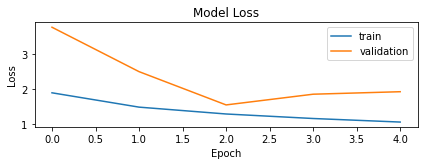

In [ ]:
#Plotting the loss curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

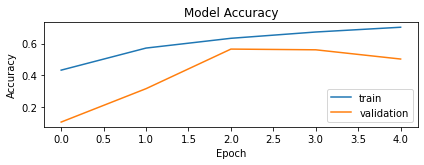

In [ ]:
#Plotting the accuracy curves
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.tight_layout()

In [ ]:
predictions = dense_net.predict_generator(X_test)
predictions

C:\Users\sgrasat\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
pred_classes = [np.argmax(element) for element in predictions]
pred_classes[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_flatten = y_test.flatten()
y_flatten

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

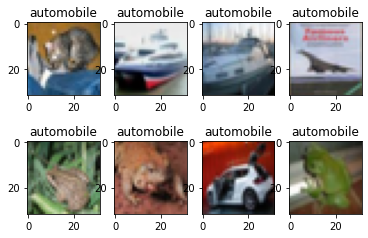

In [ ]:
import matplotlib.pyplot as plt
for i in range(8):
    # define subplot
    plt.subplot(2,4, i+1)
    plt.title(classes[pred_classes[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
# show the figure
plt.show()

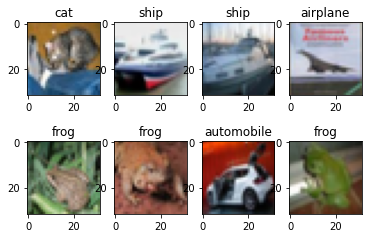

In [ ]:
for i in range(8):
    # define subplot
    plt.subplot(2,4, i+1)
    plt.title(classes[y_flatten[i]])
    # plot raw pixel data
    plt.imshow(X_test[i])
#show the figure
plt.show()

In [ ]:
from sklearn import metrics
print("Test Accuracy = ", metrics.accuracy_score(y_flatten, preds))

Test Accuracy =  0.1
